# Contents

### 1 Import Packages


### 2 Load Data

#### 2.1 Checking for NULLs

#### 2.2 Handling NULLs

#### 2.3 Handling dates


### 3 Handling Data

#### 3.1 Set date as index

#### 3.2 Resample Data

#### 3.3 Train/Test Split


### 4 Checking Data

#### 4.1 Visualizing the time series (Only Temp column)

#### 4.2 Decomposing the Time Series

#### 4.3 Stationarity Tests - Augmented Dickey Fuller Test (ADF)


### 5 Determining the parameters for ARIMA (p, q)

#### 5.1 Auto correlation plots

#### 5.2 ARIMA (Trying with the selected parameters)

#### 5.3 Model Diagnostics (Residuals)

#### 5.4 Forecasting on a Train/Test split

#### 5.5 Plotting the forecast values and the true values

#### 5.6 Plotting only the actual and forecast values

#### 5.7 Performance Metrics for the forecast


### 6 Auto ARIMA

#### 6.1 ARIMA without Seasonality

#### 6.2 Residual Plots - Auto ARIMA (Non Seasonal)

#### 6.3 Plotting the forecasts

#### 6.4 Performance Metrics for the forecast

### 1 Import Packages

In [48]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%config Completer.use_jedi = False

### 2 Load Data

In [49]:
dataset = pd.read_csv('C:\\Users\\Sarat\\Desktop\\Time Series Forecasting\\data\\Beijing_AirQuality_PM2.5.csv')

In [50]:
dataset.drop(columns=['No'], inplace=True)

#### 2.1 Checking for NULLs

In [51]:
dataset.isna().sum()

year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

#### 2.2 Handling NULLs

#### 2.3 Handling dates

#### Merging the multi column dates into one column

In [52]:
dataset['Date'] = pd.to_datetime(dataset[['year', 'month', 'day', 'hour']])

In [53]:
dataset.drop(columns=['year', 'month', 'day', 'hour'], inplace = True)

In [54]:
dataset.drop(columns=['Iws', 'Is', 'Ir'], inplace = True)

In [55]:
dataset

,pm2.5,DEWP,TEMP,PRES,cbwd,Date
0,NaN,-21,-11.0,1021.0,NW,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,2010-01-01 04:00:00
...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,2014-12-31 19:00:00
43820,10.0,-22,-3.0,1034.0,NW,2014-12-31 20:00:00
43821,10.0,-22,-3.0,1034.0,NW,2014-12-31 21:00:00
43822,8.0,-22,-4.0,1034.0,NW,2014-12-31 22:00:00


In [56]:
dataset.drop(columns=['cbwd'], inplace = True)

### 3 Handling Data

#### 3.1 Set date as index

In [57]:
dataset_2 = dataset.set_index('Date')

#### 3.2 Resample Data

In [58]:
dataset_3 = dataset_2.resample('D').mean()

In [59]:
dataset_3.isnull().sum()

pm2.5    37
DEWP      0
TEMP      0
PRES      0
dtype: int64

In [60]:
dataset_3.replace(np.nan, 0, inplace=True)

In [61]:
dataset_3

,pm2.5,DEWP,TEMP,PRES
Date,,,,
2010-01-01,0.000000,-18.750000,-6.750000,1017.083333
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000
...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333
2014-12-28,197.375000,-10.791667,1.583333,1019.958333
2014-12-29,159.000000,-12.333333,0.750000,1013.750000


#### 3.3 Train/Test Split

#### Since we shouldn't shuffle the dataset we can just split the dataset using the date index

In [108]:
datasetTrain = dataset_3[:'2014-06-30']

datasetTest = dataset_3['2014-07-01':]

In [109]:
datasetTrain

,pm2.5,DEWP,TEMP,PRES
Date,,,,
2010-01-01,0.000000,-18.750000,-6.750000,1017.083333
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000
...,...,...,...,...
2014-06-26,120.875000,20.416667,26.916667,1002.833333
2014-06-27,18.625000,13.125000,28.458333,1006.083333
2014-06-28,20.166667,13.166667,29.333333,1005.250000


In [111]:
datasetTest

,pm2.5,DEWP,TEMP,PRES
Date,,,,
2014-07-01,102.916667,18.916667,27.833333,1004.333333
2014-07-02,66.041667,20.666667,23.083333,1003.083333
2014-07-03,209.791667,21.958333,25.791667,1001.000000
2014-07-04,204.500000,22.583333,27.583333,1004.333333
2014-07-05,120.708333,21.833333,26.916667,1006.583333
...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333
2014-12-28,197.375000,-10.791667,1.583333,1019.958333
2014-12-29,159.000000,-12.333333,0.750000,1013.750000


### 4 Checking Data

#### 4.1 Visualizing the time series (Only one column - Univariate)

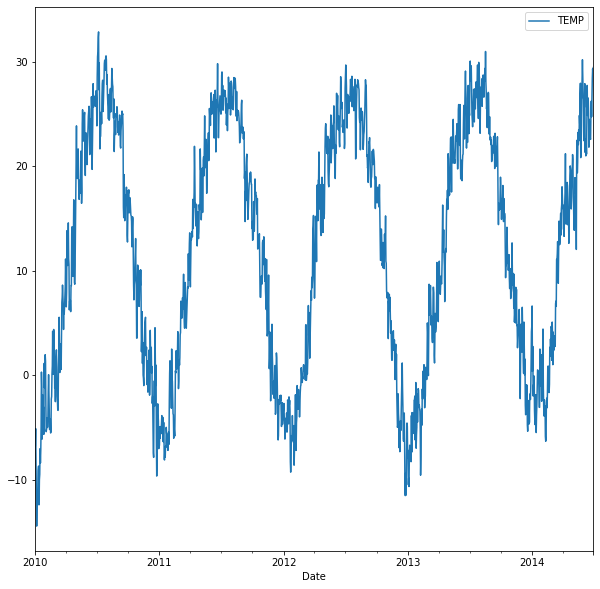

In [112]:
datasetTrain[['TEMP']].plot(figsize=(10, 10))
plt.show()

#### 4.2 Decomposing the Time Series - Into trend, seasonality and noise

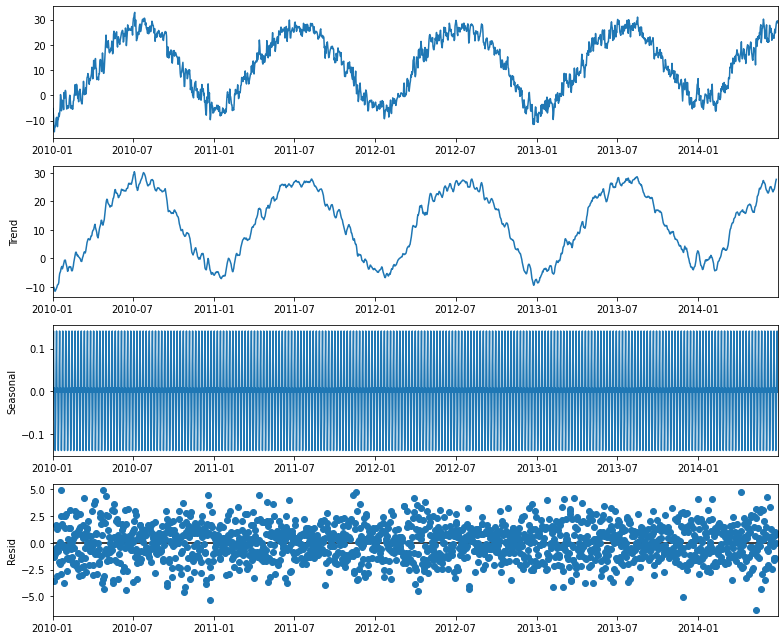

In [113]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(datasetTrain[['TEMP']], model='additive')
fig = decomposition.plot()
plt.show()

#### 4.3 Stationarity Tests - Augmented Dickey Fuller Test (ADF)

In [114]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

##### Checking our data

In [115]:
adf_test(datasetTrain[['TEMP']])

Test Statistic            -2.073376
p-value                    0.255354
# Lags                     8.000000
# Observations          1633.000000
Critical Value (1%)       -3.434361
Critical Value (5%)       -2.863312
Critical Value (10%)      -2.567713
dtype: float64
 Series is Non-Stationary


In [116]:
datasetTrain_diff = datasetTrain.diff()

In [117]:
datasetTrain_diff.dropna(how='all', inplace=True)

### 5 Determining the parameters for ARIMA (p, q)

#### 5.1 Auto correlation plots

#### Before differencing

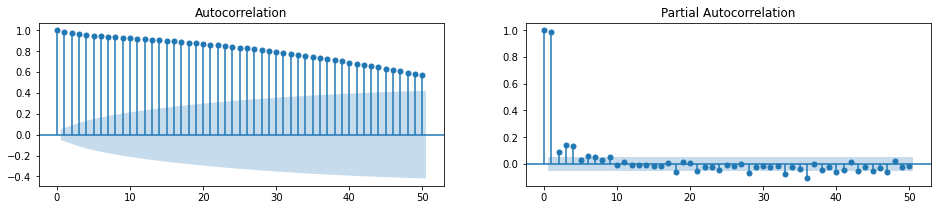

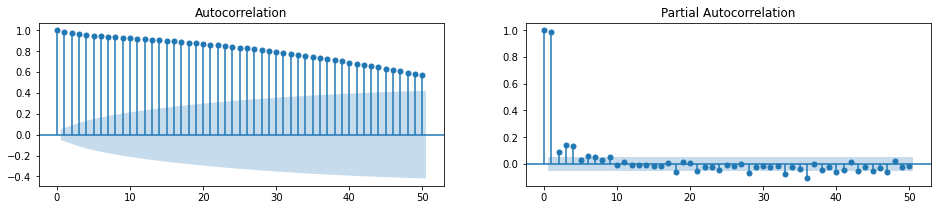

In [71]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(datasetTrain.TEMP.tolist(), lags=50, ax=axes[0])
plot_pacf(datasetTrain.TEMP.tolist(), lags=50, ax=axes[1])

#### After differencing

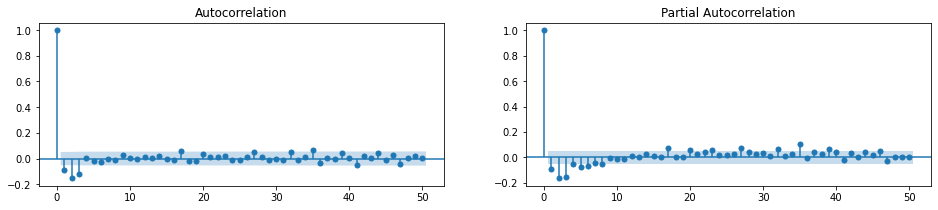

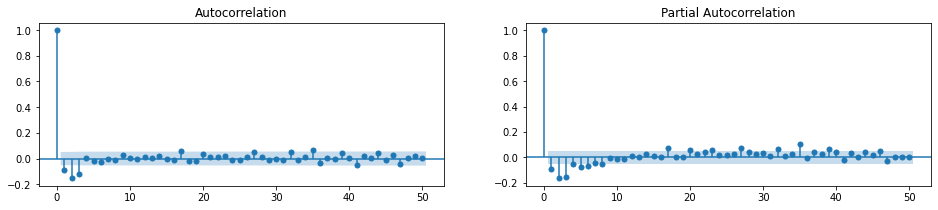

In [72]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(datasetTrain_diff.TEMP.tolist(), lags=50, ax=axes[0])
plot_pacf(datasetTrain_diff.TEMP.tolist(), lags=50, ax=axes[1])

##### The PACF plot shows the 1st lag cutting off, therefore the p value is 1
##### The ACF plot shows the 1st lag cutting off, therefore the q value is 1

#### 5.2 ARIMA (Trying with the selected parameters)

In [73]:
# p = 1, d = 1, q = 1

model = None
model = ARIMA(datasetTrain[['TEMP']], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3081.353
Date:                Tue, 25 May 2021   AIC                           6168.706
Time:                        09:24:52   BIC                           6184.565
Sample:                    01-01-2010   HQIC                          6174.622
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5924      0.052     11.359      0.000       0.490       0.695
ma.L1         -0.8020      0.039    -20.699      0.000      -0.878      -0.726
sigma2         3.9870      0.134     29.747      0.0

#### 5.3 Model Diagnostics (Residuals)

#### Residuals are the errors of the forecast. The difference between the actual values and the values of the fitted model
#### We want the residuals to be normally distributed and show now patterns. They must be random.
#### The plots below show the distribution of residuals

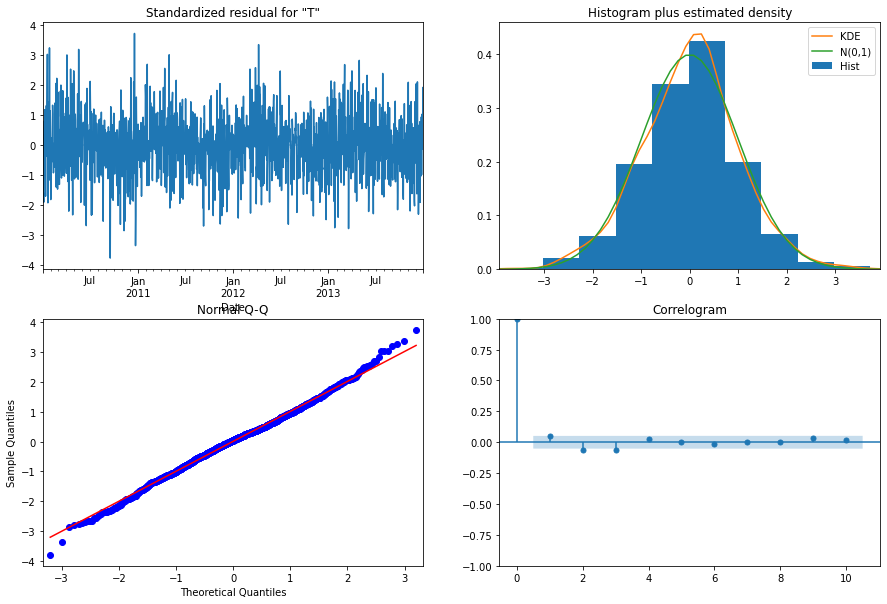

In [74]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.show()

#### 5.4 Forecasting on a Train/Test split

In [99]:
model = None
model = ARIMA(datasetTrain[['TEMP']], order=(14, 1, 14))  
fitted = model.fit()

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 5.5 Plotting the forecast values and the true values

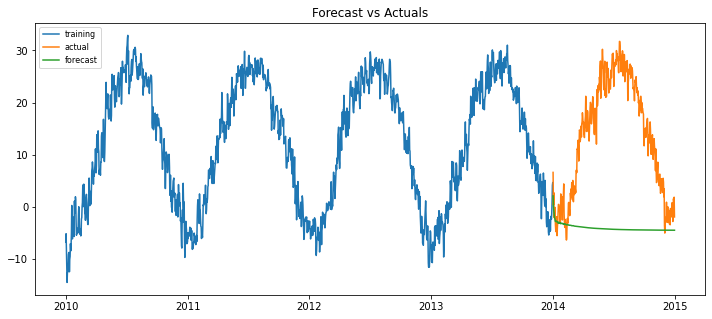

In [100]:
# Forecast
fc = fitted.forecast(len(datasetTest), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=datasetTest[['TEMP']].index)

# Plot
plt.figure(figsize=(12,5))
# Training data
plt.plot(datasetTrain[['TEMP']], label='training')
# Test data actual values
plt.plot(datasetTest[['TEMP']], label='actual')
# Forecasted values
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 5.6 Plotting only the actual and forecast values

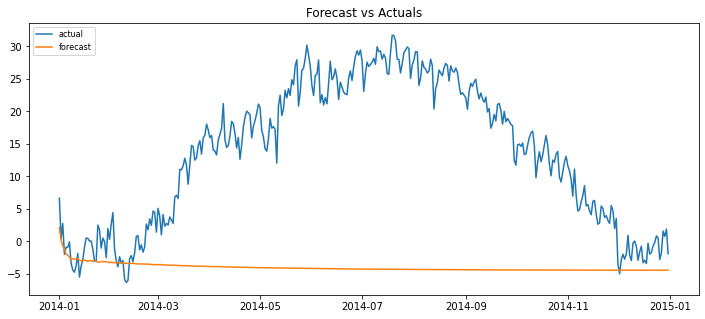

In [101]:
# Forecast
fc = fitted.forecast(len(datasetTest), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=datasetTest[['TEMP']].index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(datasetTest[['TEMP']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 5.7 Performance Metrics for the forecast

#### Mean Absolute Error and Mean Absolute Percentage Error

In [78]:
mae = mean_absolute_error(fc, datasetTest[['TEMP']].values)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(fc, datasetTest[['TEMP']].values)
print('MAPE: %.3f' % mape)

MAE: 13.280
MAPE: 6.719


### 6 Auto ARIMA

#### This model will determine the best values for the parameters p, q, d

#### 6.1 ARIMA without Seasonality

In [118]:
model = None
model = pm.auto_arima(datasetTrain[['TEMP']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6973.812, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7082.293, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7065.366, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7054.911, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7080.476, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6962.594, Time=0.99 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7022.690, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6963.761, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6963.799, Time=2.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6964.018, Time=1.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6990.041, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6965.150, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6961.438, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6972.655, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0]          

#### 6.2 Residual Plots - Auto ARIMA (Non Seasonal)

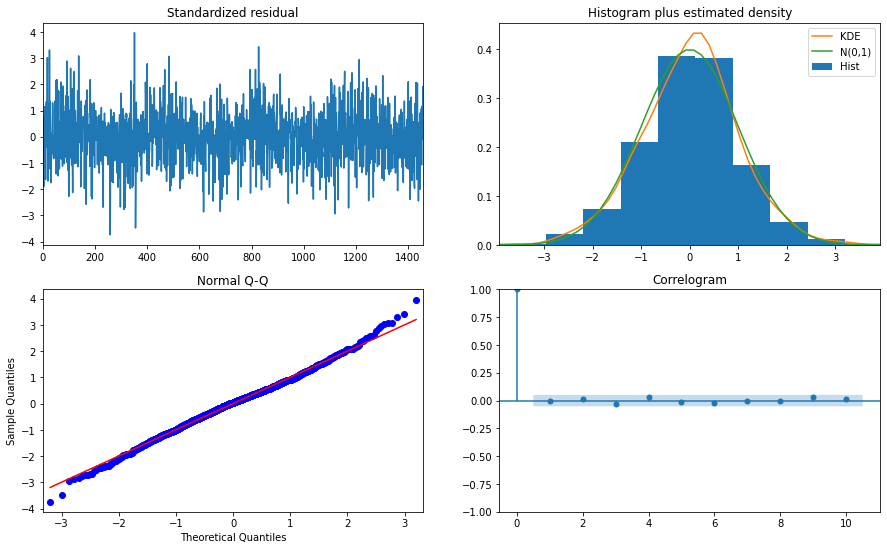

In [80]:
model.plot_diagnostics(figsize=(15,9))
plt.show()

#### 6.3 Plotting the forecasts

In [119]:
fitted = None

fitted = model.fit(datasetTrain[['TEMP']])

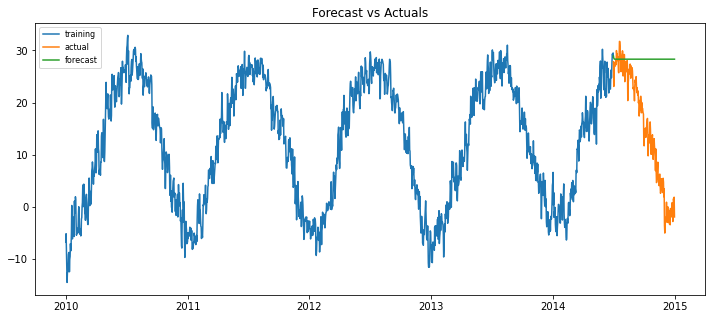

In [120]:
# Forecast
fc = fitted.predict(len(datasetTest))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=datasetTest.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(datasetTrain[['TEMP']], label='training')
plt.plot(datasetTest[['TEMP']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

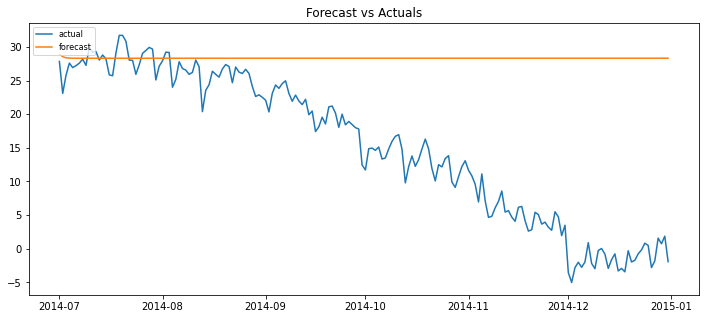

In [121]:
# Forecast
fc = fitted.predict(len(datasetTest))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=datasetTest.index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(datasetTest[['TEMP']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 6.4 Performance Metrics for the forecast

In [92]:
mae = mean_absolute_error(datasetTest['TEMP'], fc_series)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(datasetTest['TEMP'], fc_series)
print('MAPE: %.3f' % mape)

MAE: 13.275
MAPE: 1.706
